# San Francisco Crime Classification 
### https://www.kaggle.com/c/sf-crime

## I. Description of Problem and Data Set

Crime prediction based on historical data has always been a hot topic in statistical analysis.  With the onset of machine learning algorithms, this has become even more dominant in recent years.  However, accurately predicting that a certain crime is about to occur is very hard given the presented features.  In this Kaggle competition, we are asked to predict the probability of each crime category given a dataset with location and time features.

The training data set contains the following raw features:

Dates - date and time of crime	
Category - category of crime, the dependent variable	
Descript - description of the crime	
DayOfWeek - the day of the week (i.e. Monday, Tuesday, etc)	
PdDistrict - the police district in San Francisco	
Resolution - the resolution of the crime (i.e. arrested, cleared, none, etc)	
Address	- the address of the crime  
X - the X coordinate of the location  	
Y - the Y coordinate of the location

The test data contains the following raw features:

Id - ID of the incident  
Dates - date and time of crime	
DayOfWeek - the day of the week (i.e. Monday, Tuesday, etc)	
PdDistrict - the police district in San Francisco	
Address	- the address of the crime  
X - the X coordinate of the location  	
Y - the Y coordinate of the location

Information from Kaggle:  
 
"This dataset contains incidents derived from SFPD Crime Incident Reporting system. The data ranges from 1/1/2003 to 5/13/2015. The training set and test set rotate every week, meaning week 1,3,5,7... belong to test set, week 2,4,6,8 belong to training set."

## II. Library Import

In [272]:
import warnings
warnings.filterwarnings('ignore')

# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shapefile
import time

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV
from sklearn import preprocessing
from sklearn.mixture import GaussianMixture
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss

## III. Data Import
Import data and check the shape of train and test set.

In [2]:
import csv
from datetime import datetime
from time import time
ff = "./Data/train.csv" # you will need to edit this directory
with open(ff, 'rt') as f:
    reader = csv.reader(f)
    train_data = list(reader)
ff = "./Data/test.csv" # you will need to edit this directory
with open(ff, 'rt') as f:
    reader = csv.reader(f)
    test_data = list(reader)
    
#Convert to pandas data frame for better analysis
train_data_full = pd.DataFrame(train_data[1:], columns = train_data[0])
test_data = pd.DataFrame(test_data[1:], columns = test_data[0])
print ("Shape of train data", train_data_full.shape)
print ("Shape of test data", test_data.shape)

Shape of train data (878049, 9)
Shape of test data (884262, 7)


### Section for functions that will be re-used throughout the notebook

In [379]:
## EDA Graphs
def graph_counts(data, title, x, y, xlabel, ylabel, palette="Greens_d"):
    sns.barplot(x=x,y=y,data=data, palette=palette)
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=90)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    
#create functions to extract the needed datetime features
def season(date):
    spring = range(80, 172)
    summer = range(172, 264)
    fall = range(264, 355)
    if date.timetuple().tm_yday in spring:
        return 2, "Spring" #Spring
    elif date.timetuple().tm_yday in summer:
        return 3, "Summer" #Summer
    elif date.timetuple().tm_yday in fall:
        return 4, "Fall" #Fall
    else:
        return 1, "Winter" #Winter
    
def getTimeCat(date):
    # extract time categories
    timecat = 4
    ts =  datetime.strptime(str(date),  '%Y-%m-%d %H:%M:%S').time()

    # --> Morning = 0400-1000
    mornStart = datetime.strptime('2016-12-31 04:01',  '%Y-%m-%d %H:%M').time()
    mornEnd = datetime.strptime('2016-12-31 10:00',  '%Y-%m-%d %H:%M').time()
    
    # --> Midday = 1000-1600
    midStart = datetime.strptime('2016-12-31 10:01',  '%Y-%m-%d %H:%M').time()
    midEnd = datetime.strptime('2016-12-31 16:00',  '%Y-%m-%d %H:%M').time()

    # --> Evening = 1600-2300
    eveStart = datetime.strptime('2016-12-31 16:01',  '%Y-%m-%d %H:%M').time()
    eveEnd = datetime.strptime('2016-12-31 23:00',  '%Y-%m-%d %H:%M').time()

    # --> Late Night = 2300-0400
    lateStart1 = datetime.strptime('2016-12-31 23:01',  '%Y-%m-%d %H:%M').time()
    lateEnd1 = datetime.strptime('2016-12-31 23:59',  '%Y-%m-%d %H:%M').time()
    lateStart2 = datetime.strptime('2016-12-31 00:01',  '%Y-%m-%d %H:%M').time()
    lateEnd2 = datetime.strptime('2016-12-31 04:01',  '%Y-%m-%d %H:%M').time()

    
    if ts >= mornStart and ts <= mornEnd:
      timecat = 0,'morning' #morning
    elif ts >= midStart and ts <= midEnd:
      timecat = 1, 'midday' #midday
    elif ts >= eveStart and ts <= eveEnd:
      timecat = 2, 'evening' #evening
    elif ts >= lateStart1 and ts <= lateEnd1:
      timecat = 3, 'late_night' #late night
    elif ts >= lateStart2 and ts <= lateEnd2:
      timecat = 3, 'late_night' #late night

    return timecat

def month_str(date):
    if date.month == 1:
        return "Jan"
    if date.month == 2:
        return "Feb"
    if date.month == 3:
        return "Mar"
    if date.month == 4:
        return "Apr"
    if date.month == 5:
        return "May"
    if date.month == 6:
        return "Jun"
    if date.month == 7:
        return "Jul"
    if date.month == 8:
        return "Aug"
    if date.month == 9:
        return "Sep"
    if date.month == 10:
        return "Oct"
    if date.month == 11:
        return "Nov"
    if date.month == 11:
        return "Dec"

def normalize(series_field, df, new_field_name):
    scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    series_field = series_field.reshape((len(series_field), 1))
    scaler = scaler.fit(series_field)
    normalized = scaler.transform(series_field)
    df[new_field_name] = normalized
    return df

def standardize(series_field, df, new_field_name):
    scaler = preprocessing.StandardScaler()
    series_field = series_field.reshape((len(series_field), 1))
    scaler = scaler.fit(series_field)
    standardized = scaler.transform(series_field)
    df[new_field_name] = standardized
    return df


# Grid Search CV to determine best estimators for each model
def best_e_nb(alphas, train1, train2):

    clf = BernoulliNB()
    g = GridSearchCV(clf, param_grid = alphas)
    g.fit(train1, train2)
        
    return (g)

def best_e_lr(Cs, train1, train2):

    clf = LogisticRegression()
    g = GridSearchCV(clf, param_grid = Cs)
    g.fit(train1, train2)
        
    return (g)



## IV. EDA

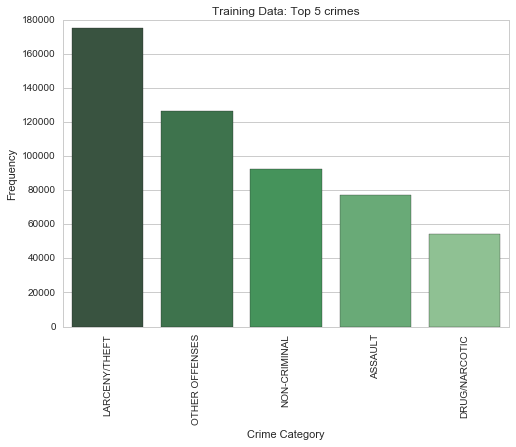

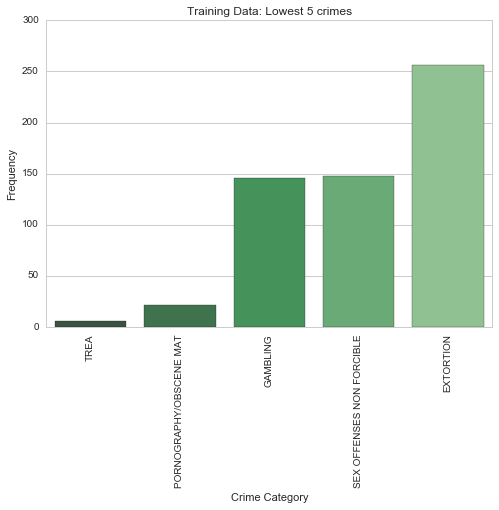

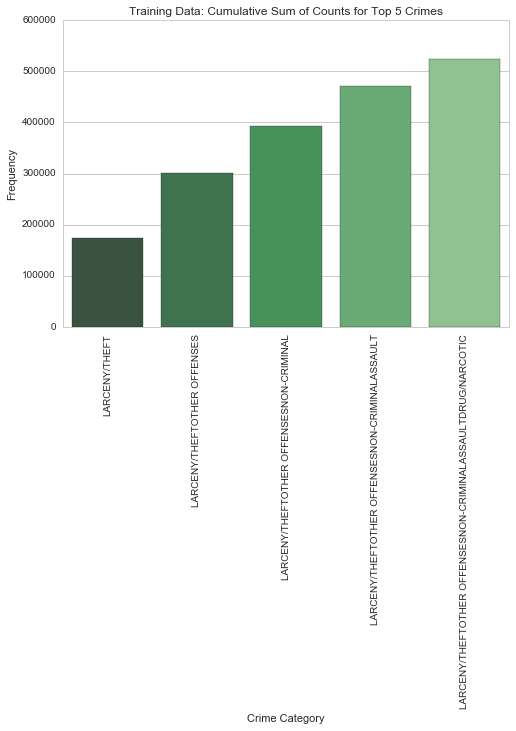

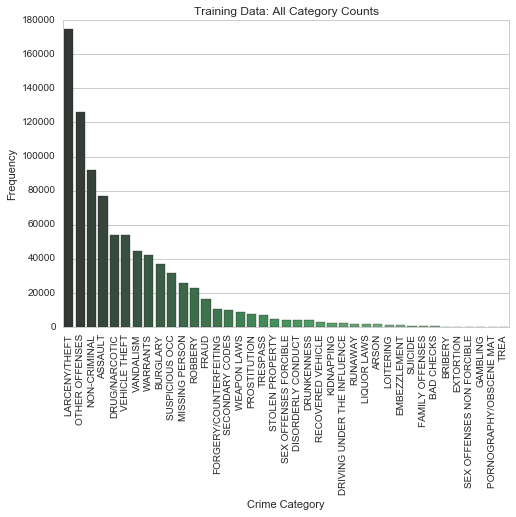

In [4]:
category_count = train_data_full.groupby(['Category'], as_index=False)['Dates'].count()

data1 = category_count.sort_values(ascending=False, by='Dates')[:5]
data2 = category_count.sort_values(ascending=True, by='Dates')[:5]
data3 = category_count.sort_values(ascending=False, by='Dates')[:5].cumsum()
data4 = category_count.sort_values(ascending=False, by='Dates')

title1 = 'Training Data: Top 5 crimes'
title2 = 'Training Data: Lowest 5 crimes'
title3 = 'Training Data: Cumulative Sum of Counts for Top 5 Crimes'
title4 = 'Training Data: All Category Counts'

palette="Greens_d"

graph_counts(data1, title1, 'Category', 'Dates', 'Crime Category', 'Frequency', palette)
graph_counts(data2, title2, 'Category', 'Dates', 'Crime Category', 'Frequency', palette)
graph_counts(data3, title3, 'Category', 'Dates', 'Crime Category', 'Frequency', palette)
graph_counts(data4, title4, 'Category', 'Dates', 'Crime Category', 'Frequency', palette)


#Top 5 crimes make up over 50% of the training data set.
#Focusing on prediciting these as accurately as possible may give us a better accuracy score overall 

## V. Feature Engineering

### Creating Neighborhood Feature

Converting X and Y coordinates into San Francisco neighborhoods using Zillows database via shapefiles

Shapefiles can be read via the pyshp package (https://pypi.python.org/pypi/pyshp)

https://www.zillow.com/howto/api/neighborhood-boundaries.htm

In [5]:
#read in the shapefile provided by zillow for california
sf = shapefile.Reader("./Data/ZillowNeighborhoods-CA.shp")
fields = sf.fields[1:] 
field_names = [field[0] for field in fields] 
nhood_list = []

#iterate through the shapefile records and retrieve the properties of each shapefile record 
#as well as its bbox coordinates 
#bbox: If the shape type contains multiple points this tuple describes the lower left (x,y) 
#coordinate and upper right corner coordinate creating a complete box around the points. 
#If the shapeType is a Null (shapeType == 0) then an AttributeError is raised.

#we will use the bbox to determine if our X and Y coordinates from the training data
#fall within the bbox of each neighborhood and then assign that neighborhood to the training data
for r in sf.shapeRecords():  
    atr = dict(zip(field_names, r.record))
    bbox = r.shape.bbox
    if atr['City'] == 'San Francisco':
        #print (dict(properties=atr,bbox=bbox))
        new_dict=dict(properties=atr,bbox=bbox)
        nhood_list.append(new_dict)
        
def coord_in_bbox(bbox, X, Y):
    if X>=bbox[0] and X<=bbox[2] and Y>=bbox[1] and Y<=bbox[3]:
        return True
    else:
        return False

def neighborhood(nhood_list, X, Y):
    for n in nhood_list:
        bbox = n['bbox']
        X = float(X)
        Y = float(Y)
        if coord_in_bbox(bbox, X, Y):
            return n['properties']['Name']

#Add neighborhood to train data
train_data_full['Neighborhood'] = train_data_full.apply(lambda x: neighborhood(nhood_list,x['X'],x['Y']),axis=1)
        



Neighborhood Counts

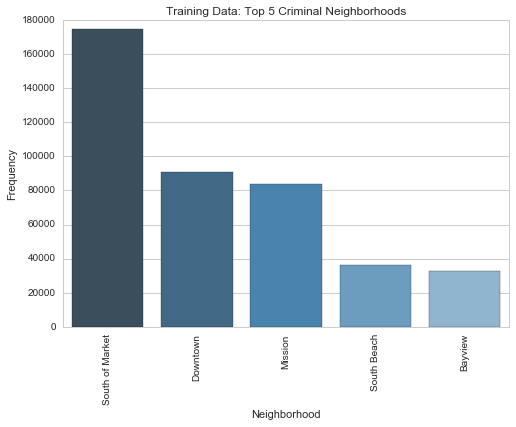

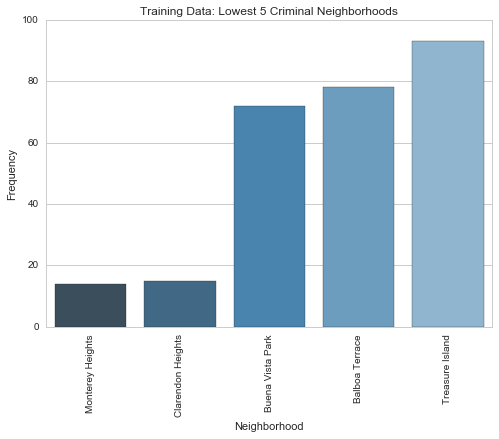

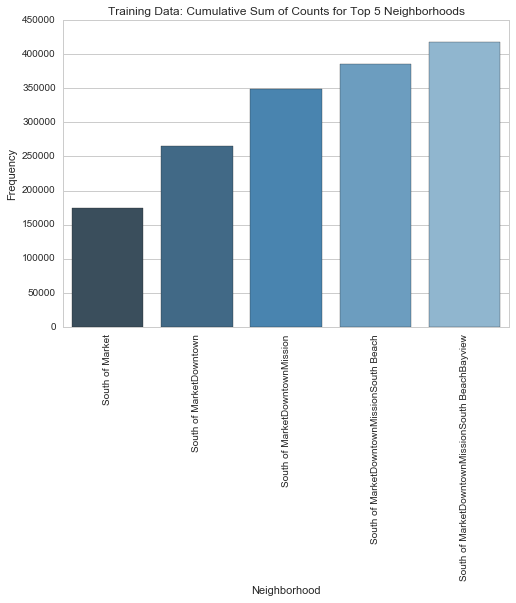

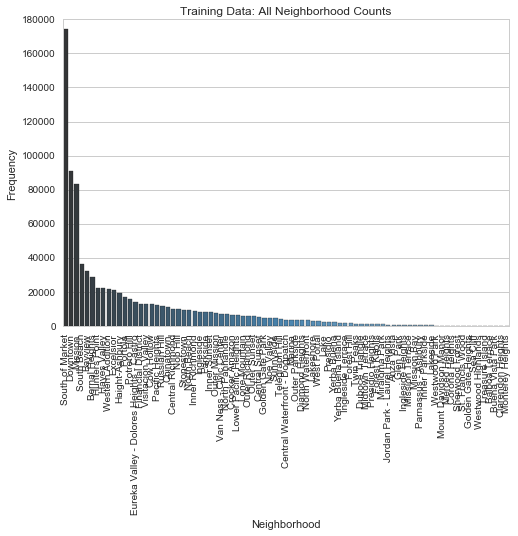

In [6]:
neighborhood_count = train_data_full.groupby(['Neighborhood'], as_index=False)['Dates'].count()

data1 = neighborhood_count.sort_values(ascending=False, by='Dates')[:5]
data2 = neighborhood_count.sort_values(ascending=True, by='Dates')[:5]
data3 = neighborhood_count.sort_values(ascending=False, by='Dates')[:5].cumsum()
data4 = neighborhood_count.sort_values(ascending=False, by='Dates')

title1 = 'Training Data: Top 5 Criminal Neighborhoods'
title2 = 'Training Data: Lowest 5 Criminal Neighborhoods'
title3 = 'Training Data: Cumulative Sum of Counts for Top 5 Neighborhoods'
title4 = 'Training Data: All Neighborhood Counts'

palette="Blues_d"

graph_counts(data1, title1, 'Neighborhood', 'Dates', 'Neighborhood', 'Frequency', palette)
graph_counts(data2, title2, 'Neighborhood', 'Dates', 'Neighborhood', 'Frequency', palette)
graph_counts(data3, title3, 'Neighborhood', 'Dates', 'Neighborhood', 'Frequency', palette)
graph_counts(data4, title4, 'Neighborhood', 'Dates', 'Neighborhood', 'Frequency', palette)


#Top 5 neighborhoods make up almost 50% of the training data set.
#Also next steps is to bring in the category counts by neighborhood to see how these relate as well.

Overlaying Category and Neighborhood

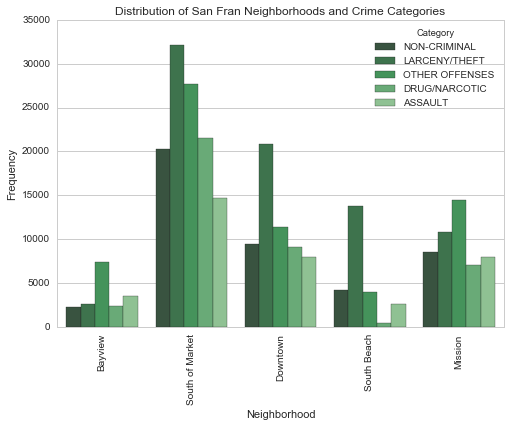

In [7]:
train_data_top5 = train_data_full[train_data_full['Category'].isin(['LARCENY/THEFT','OTHER OFFENSES', 'NON-CRIMINAL','ASSAULT', 'DRUG/NARCOTIC'])]
train_data_top5 = train_data_top5[train_data_top5['Neighborhood'].isin(['South of Market', 'Downtown', 'Mission', 'South Beach', 'Bayview'])]
ax = sns.countplot(x="Neighborhood", hue='Category', data=train_data_top5, palette="Greens_d")
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.title('Distribution of San Fran Neighborhoods and Crime Categories')
plt.xlabel('Neighborhood')
plt.ylabel('Frequency')

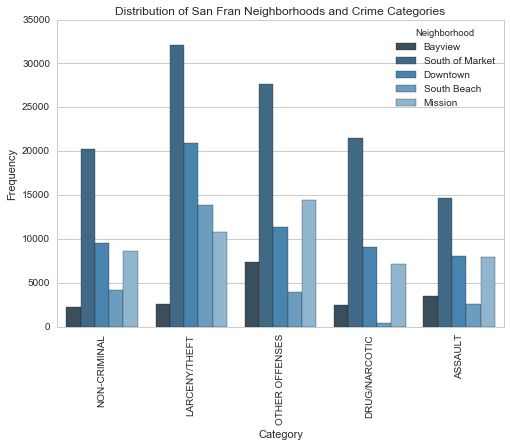

In [8]:
train_data_top5 = train_data_full[train_data_full['Category'].isin(['LARCENY/THEFT','OTHER OFFENSES', 'NON-CRIMINAL','ASSAULT', 'DRUG/NARCOTIC'])]
train_data_top5 = train_data_top5[train_data_top5['Neighborhood'].isin(['South of Market', 'Downtown', 'Mission', 'South Beach', 'Bayview'])]
ax = sns.countplot(x="Category", hue='Neighborhood', data=train_data_top5, palette="Blues_d")
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.title('Distribution of San Fran Neighborhoods and Crime Categories')
plt.xlabel('Category')
plt.ylabel('Frequency')

### Generate Date and Time Features
Season  
Month  
Week  
Day / Day of Week  
Hour

In [9]:
#convert Dates to datetime
train_data_full['FinalDate'] = pd.to_datetime(train_data_full['Dates'], format='%Y-%m-%d %H:%M:%S')

#apply the functions
train_data_full['Season'], train_data_full['Season_Str'] = zip(*train_data_full['FinalDate'].map(season))
train_data_full['DayOfMonth'] = train_data_full['FinalDate'].apply(lambda x: x.day)
train_data_full['Week'] = train_data_full['FinalDate'].apply(lambda x: x.week)
train_data_full['Month'] = train_data_full['FinalDate'].apply(lambda x: x.month)
train_data_full['Month_Str'] = train_data_full['FinalDate'].map(month_str)
train_data_full['TimeCat'], train_data_full['TimeCat_Str'] = zip(*train_data_full['FinalDate'].map(getTimeCat))
train_data_full['Hour'] = train_data_full['FinalDate'].apply(lambda x: str(x.hour) + ":00")

#Normalize and Standardize Date and X,Y
train_data_full = normalize(train_data_full['FinalDate'], train_data_full, 'DateNorm')
train_data_full = standardize(train_data_full['FinalDate'], train_data_full, 'DateStand')
train_data_full = normalize(train_data_full['X'], train_data_full, 'XNorm')
train_data_full = standardize(train_data_full['X'], train_data_full, 'XStand')
train_data_full = normalize(train_data_full['Y'], train_data_full, 'YNorm')
train_data_full = standardize(train_data_full['Y'], train_data_full, 'YStand')
train_data_full = standardize(train_data_full['DateNorm'], train_data_full, 'DateNS')
train_data_full = standardize(train_data_full['XNorm'], train_data_full, 'XNS')
train_data_full = standardize(train_data_full['YNorm'], train_data_full, 'YNS')

C:\Users\sriva\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype datetime64[ns] was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)
C:\Users\sriva\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype datetime64[ns] was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
C:\Users\sriva\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)
C:\Users\sriva\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


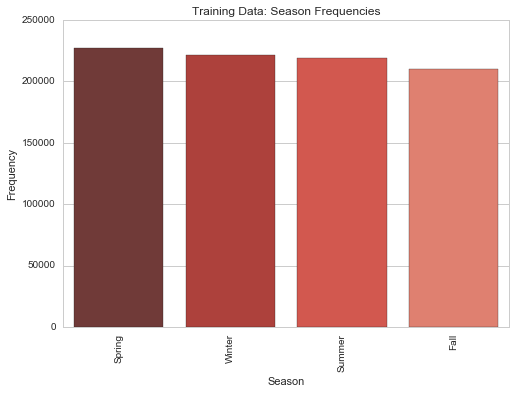

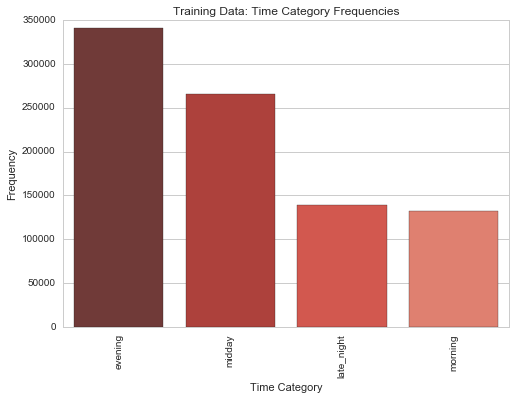

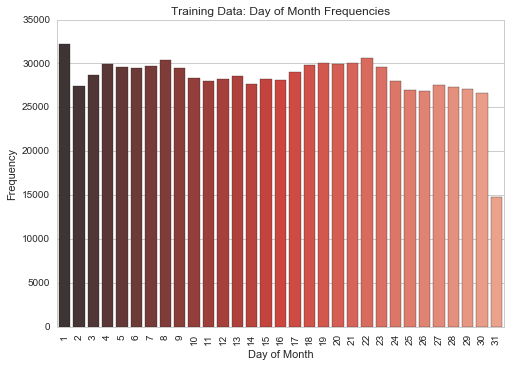

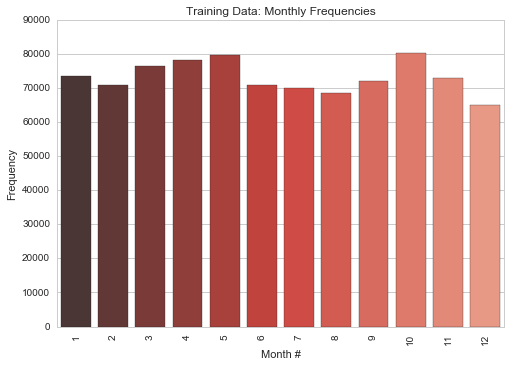

In [10]:
season_count = train_data_full.groupby(['Season_Str'], as_index=False)['Dates'].count()
timecat_count = train_data_full.groupby(['TimeCat_Str'], as_index=False)['Dates'].count()
daymonth_count = train_data_full.groupby(['DayOfMonth'], as_index=False)['Dates'].count()
month_count = train_data_full.groupby(['Month'], as_index=False)['Dates'].count()

data1 = season_count.sort_values(ascending=False, by='Dates')
data2 = timecat_count.sort_values(ascending=False, by='Dates')
data3 = daymonth_count.sort_values(ascending=False, by='Dates')
data4 = month_count.sort_values(ascending=False, by='Dates')

title1 = 'Training Data: Season Frequencies'
title2 = 'Training Data: Time Category Frequencies'
title3 = 'Training Data: Day of Month Frequencies'
title4 = 'Training Data: Monthly Frequencies'

palette="Reds_d"

graph_counts(data1, title1, 'Season_Str', 'Dates', 'Season', 'Frequency', palette)
graph_counts(data2, title2, 'TimeCat_Str', 'Dates', 'Time Category', 'Frequency', palette)
graph_counts(data3, title3, 'DayOfMonth', 'Dates', 'Day of Month', 'Frequency', palette)
graph_counts(data4, title4, 'Month', 'Dates', 'Month #', 'Frequency', palette)

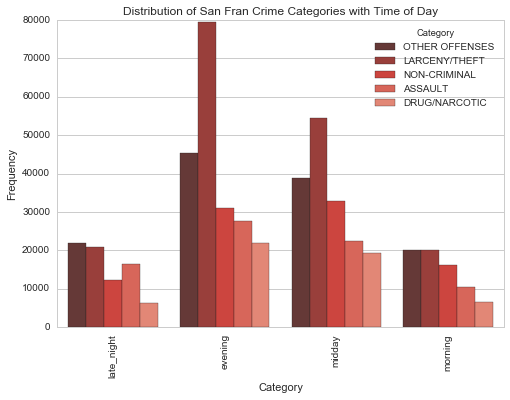

In [11]:
train_data_top5 = train_data_full[train_data_full['Category'].isin(['LARCENY/THEFT','OTHER OFFENSES', 'NON-CRIMINAL','ASSAULT', 'DRUG/NARCOTIC'])]
train_data_top5 = train_data_top5[train_data_top5['TimeCat_Str'].isin(['morning', 'midday', 'evening', 'late_night'])]
ax = sns.countplot(x="TimeCat_Str", hue='Category', data=train_data_top5, palette="Reds_d")
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.title('Distribution of San Fran Crime Categories with Time of Day')
plt.xlabel('Category')
plt.ylabel('Frequency')

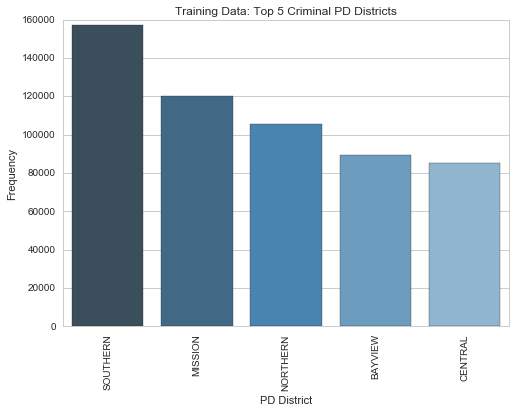

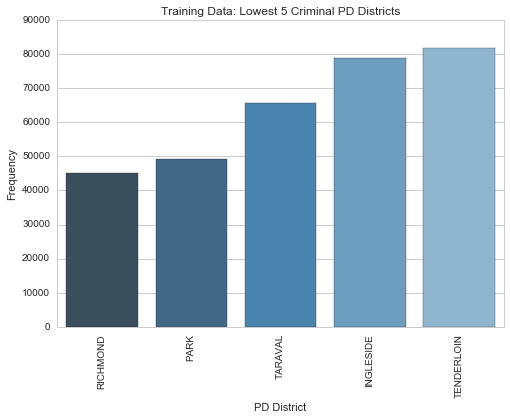

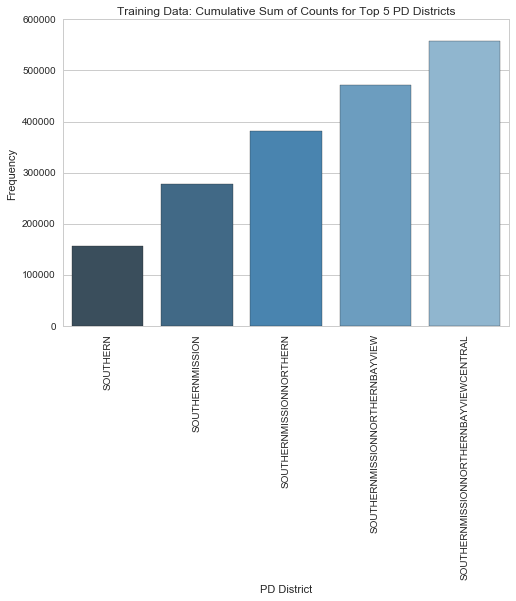

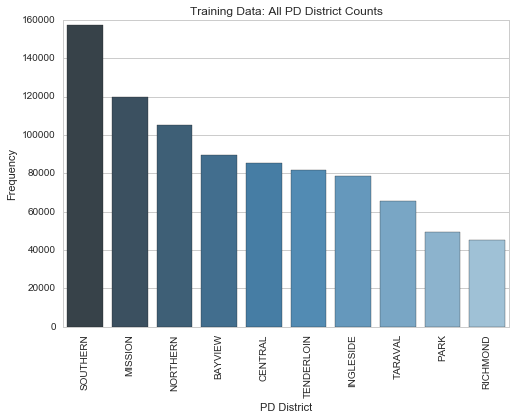

In [12]:
district_count = train_data_full.groupby(['PdDistrict'], as_index=False)['Dates'].count()

data1 = district_count.sort_values(ascending=False, by='Dates')[:5]
data2 = district_count.sort_values(ascending=True, by='Dates')[:5]
data3 = district_count.sort_values(ascending=False, by='Dates')[:5].cumsum()
data4 = district_count.sort_values(ascending=False, by='Dates')

title1 = 'Training Data: Top 5 Criminal PD Districts'
title2 = 'Training Data: Lowest 5 Criminal PD Districts'
title3 = 'Training Data: Cumulative Sum of Counts for Top 5 PD Districts'
title4 = 'Training Data: All PD District Counts'

palette="Blues_d"

graph_counts(data1, title1, 'PdDistrict', 'Dates', 'PD District', 'Frequency', palette)
graph_counts(data2, title2, 'PdDistrict', 'Dates', 'PD District', 'Frequency', palette)
graph_counts(data3, title3, 'PdDistrict', 'Dates', 'PD District', 'Frequency', palette)
graph_counts(data4, title4, 'PdDistrict', 'Dates', 'PD District', 'Frequency', palette)

In [13]:
#get a list of features and their data types
train_data_full.dtypes

Dates                   object
Category                object
Descript                object
DayOfWeek               object
PdDistrict              object
Resolution              object
Address                 object
X                       object
Y                       object
Neighborhood            object
FinalDate       datetime64[ns]
Season                   int32
Season_Str              object
DayOfMonth               int64
Week                     int64
Month                    int64
TimeCat                  int32
TimeCat_Str             object
Hour                     int64
DateNorm               float64
DateStand              float64
XNorm                  float64
XStand                 float64
YNorm                  float64
YStand                 float64
DateNS                 float64
XNS                    float64
YNS                    float64
dtype: object

## VI. Model Processing

In [14]:
#convert to matrix for model processing
#Create sets of data where time and coords are standardized, scaled from [0,1], both
X_full = train_data_full.as_matrix()
Y = train_data_full["Category"].as_matrix()
X = train_data_full[["Dates","X","Y"]].as_matrix()
X_Norm = train_data_full[["DateNorm","XNorm","YNorm"]].as_matrix()
X_Std = train_data_full[["DateStand","XStand","YStand"]].as_matrix()
X_NS = train_data_full[["DateNS","XNS","YNS"]].as_matrix()
#Data set to investigate importance of time dimension
X_2d = train_data_full[["XStand","YStand"]].as_matrix()
X_cat = train_data_full[["Hour","TimeCat","DayOfMonth", "Week","Month","Season","X","Y"]].as_matrix()

In [15]:
#Encode categories into digits
le = preprocessing.LabelEncoder()
le.fit(Y)
n_classes = len(le.classes_)
Y_le = le.transform(Y)

#Shuffle the transformed data
np.random.seed(0)
shuffle = np.random.permutation(np.arange(X_full.shape[0]))
X_Norm, X_Std, X_NS, X_2d, Y_le = X_Norm[shuffle],X_Std[shuffle],X_NS[shuffle],X_2d[shuffle],Y_le[shuffle]

trn_N, trn_S, trn_NS, trn_2d, tr_labels = X_Norm[:len(X_full)//2], \
                                            X_Std[:len(X_full)//2], \
                                            X_NS[:len(X_full)//2], \
                                            X_2d[:len(X_full)//2], \
                                            Y_le[:len(X_full)//2] 
                
tst_N, tst_S, tst_NS, tst_2d, tst_labels = X_Norm[len(X_full)//2:], \
                                            X_Std[len(X_full)//2:], \
                                            X_NS[len(X_full)//2:], \
                                            X_2d[len(X_full)//2:], \
                                            Y_le[len(X_full)//2:] 
trns = [trn_N, trn_S, trn_NS, trn_2d]
tsts = [tst_N, tst_S, tst_NS, tst_2d]

### Naive Bayes and Logistic Regression

#### Initial Models

In [17]:
# Another look at the data
train_data_full.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Neighborhood,...,Hour,DateNorm,DateStand,XNorm,XStand,YNorm,YStand,DateNS,XNS,YNS
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425891675136,37.7745985956747,Hayes Valley,...,23,1.000000,1.697407,0.043578,-0.107902,0.001276,0.007832,1.697407,-0.107902,0.007832
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425891675136,37.7745985956747,Hayes Valley,...,23,1.000000,1.697407,0.043578,-0.107902,0.001276,0.007832,1.697407,-0.107902,0.007832
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.42436302145,37.8004143219856,Cow Hollow,...,23,0.999997,1.697397,0.044337,-0.057541,0.001770,0.064335,1.697397,-0.057541,0.064335
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.42699532676599,37.80087263276921,Cow Hollow,...,23,0.999996,1.697395,0.043030,-0.144262,0.001778,0.065338,1.697395,-0.144262,0.065338
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438737622757,37.771541172057795,Haight-Ashbury,...,23,0.999996,1.697395,0.037198,-0.531112,0.001217,0.001140,1.697395,-0.531112,0.001140


In [131]:
# Convert crime labels to numbers
leCrime = preprocessing.LabelEncoder()
crime = leCrime.fit_transform(train_data_full.Category)

In [132]:
# The "crime" variable is now a list of numbers ranging from 0 to 38
np.unique(crime)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38], dtype=int64)

In [21]:
# Convert dates to date data type
train_data_full['Dates']  = pd.to_datetime(train_data_full['Dates'])

### Iteration 1

### The features we want to focus on first for the NB and Logistic Regression models are:

Day of Week  
PD District  
Hour

In [441]:
# Get binarized weekdays, districts, and hours
days = pd.get_dummies(train_data_full.DayOfWeek)
district = pd.get_dummies(train_data_full.PdDistrict)
hour = pd.get_dummies(train_data_full.Hour)

In [430]:
# Build new array
trainData1 = pd.concat([hour, days, district], axis=1)
trainData1['crime']=crime

In [432]:
# Create list of features for slicing
feature_day = list(set(np.unique(train_data_full["DayOfWeek"])))
feature_district = list(set(np.unique(train_data_full["PdDistrict"])))
feature_hour = list(set(np.unique(train_data_full["Hour"])))
features1 = feature_day + feature_district + feature_hour

print(features1)
feature_labels1 = ['Day of Week', 'PD District', 'Hour']

['Monday', 'Saturday', 'Friday', 'Wednesday', 'Sunday', 'Thursday', 'Tuesday', 'BAYVIEW', 'RICHMOND', 'NORTHERN', 'CENTRAL', 'PARK', 'INGLESIDE', 'TARAVAL', 'SOUTHERN', 'MISSION', 'TENDERLOIN', '0:00', '13:00', '1:00', '3:00', '11:00', '12:00', '23:00', '18:00', '22:00', '15:00', '9:00', '16:00', '4:00', '2:00', '14:00', '20:00', '21:00', '6:00', '5:00', '8:00', '7:00', '17:00', '10:00', '19:00']


In [433]:
# Split data into training and validation sets
training1, validation1 = train_test_split(trainData1, train_size=.60)

In [434]:
# Naive bayes
alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0, 15.0, 20.0, 30.0, 40.0, 50.0, 80.0, 100.0, 200.0]}
nb1 = best_e_nb(alphas,training1[features1],training1['crime'])  #get the best alpha via grid search
alpha = nb1.best_params_['alpha']
model_NB1 = BernoulliNB(alpha=alpha,binarize=0.5)
model_NB1.fit(training1[features1], training1['crime'])
predicted_NB1 = np.array(model_NB1.predict_proba(validation1[features1]))
log_loss(validation1['crime'], predicted_NB1) 

2.5884192441493465

In [435]:
# Logistic regression
#GridSearch takes too long for LR, we chose C of 1.0
C = 1.0
model_LR1 = LogisticRegression(C=C)
model_LR1.fit(training1[features1], training1['crime'])
predicted_LR1 = np.array(model_LR1.predict_proba(validation1[features1]))
log_loss(validation1['crime'], predicted_LR1) 

2.5795629449574755

### Iteration 2

### The features we want to focus on next for the NB and Logistic Regression models are:

Day of Week  
Neighborhood  
Hour

#### The idea here is that the Neighborhood feature provides a finer focus on location than PD District

In [442]:
# Get binarized neighborhoods
neighborhoods = pd.get_dummies(train_data_full.Neighborhood)

In [443]:
# Build new array
trainData2 = pd.concat([hour, days, neighborhoods], axis=1)
trainData2['crime']=crime

In [444]:
feature_day = list(set(np.unique(train_data_full["DayOfWeek"])))
feature_neighborhood = list(set(train_data_full["Neighborhood"]))
feature_hour = list(set(np.unique(train_data_full["Hour"])))
features2 = feature_day + feature_neighborhood + feature_hour
features2.remove(None)

print(features2)
feature_labels2 = ['Day of Week', 'Neighborhood', 'Hour']

['Monday', 'Saturday', 'Friday', 'Wednesday', 'Sunday', 'Thursday', 'Tuesday', 'Van Ness - Civic Center', 'Forest Knolls', 'Balboa Terrace', 'Diamond Heights', 'Nob Hill', 'Lake', 'Mission Terrace', 'North Beach', 'Treasure Island', 'Mission Bay', 'Lower Pacific Heights', 'Lakeshore', 'Western Addition', 'Inner Sunset', 'Bayview', 'Golden Gate Heights', 'Inner Richmond', 'Pacific Heights', 'Parnassus - Ashbury', 'Glen Park', 'Chinatown', 'Clarendon Heights', 'Miraloma Park', 'Westwood Highlands', 'Potrero Hill', 'Lakeside', 'Parkside', 'Crocker Amazon', 'Hunters Point', 'Haight-Ashbury', 'West Portal', 'Twin Peaks', 'Financial District', 'Forest Hill', 'Merced Heights', 'Cow Hollow', 'Yerba Buena Island', 'Sherwood Forest', 'Buena Vista Park', 'South Beach', 'Stonestown', 'Lone Mountain', 'Ingleside Heights', 'Presidio', 'Jordan Park - Laurel Heights', 'Corona Heights', 'Outer Richmond', 'Outer Sunset', 'Russian Hill', 'Mount Davidson Manor', 'Inner Parkside', 'Duboce Triangle', 'Centr

In [445]:
training2, validation2 = train_test_split(trainData2, train_size=.60)

In [446]:
# Naive bayes
alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0, 15.0, 20.0, 30.0, 40.0, 50.0, 80.0, 100.0, 200.0]}
nb2 = best_e_nb(alphas,training2[features2],training2['crime'])  #get the best alpha via grid search
alpha = nb2.best_params_['alpha']
model_NB2 = BernoulliNB(alpha=alpha,binarize=0.5)
model_NB2.fit(training2[features2], training2['crime'])
predicted_NB2 = np.array(model_NB2.predict_proba(validation2[features2]))
log_loss(validation2['crime'], predicted_NB2)

2.5690608626391058

In [447]:
# Logistic regression
#GridSearch takes too long for LR, we chose C of 1.0
C = 1.0
model_LR2 = LogisticRegression(C=C)
model_LR2.fit(training2[features2], training2['crime'])
predicted_LR2 = np.array(model_LR2.predict_proba(validation2[features2]))
log_loss(validation2['crime'], predicted_LR2) 

2.5560728782813591

### Error Analysis

#### Confusion Matrix

In [90]:
# Determine if this is the order of categories for the confusion matrix -- yes, it is
categories = np.unique(train_data_full.Category)
print(categories)

['ARSON' 'ASSAULT' 'BAD CHECKS' 'BRIBERY' 'BURGLARY' 'DISORDERLY CONDUCT'
 'DRIVING UNDER THE INFLUENCE' 'DRUG/NARCOTIC' 'DRUNKENNESS' 'EMBEZZLEMENT'
 'EXTORTION' 'FAMILY OFFENSES' 'FORGERY/COUNTERFEITING' 'FRAUD' 'GAMBLING'
 'KIDNAPPING' 'LARCENY/THEFT' 'LIQUOR LAWS' 'LOITERING' 'MISSING PERSON'
 'NON-CRIMINAL' 'OTHER OFFENSES' 'PORNOGRAPHY/OBSCENE MAT' 'PROSTITUTION'
 'RECOVERED VEHICLE' 'ROBBERY' 'RUNAWAY' 'SECONDARY CODES'
 'SEX OFFENSES FORCIBLE' 'SEX OFFENSES NON FORCIBLE' 'STOLEN PROPERTY'
 'SUICIDE' 'SUSPICIOUS OCC' 'TREA' 'TRESPASS' 'VANDALISM' 'VEHICLE THEFT'
 'WARRANTS' 'WEAPON LAWS']


In [91]:
categories_encoded = leCrime.transform(categories) 
categories_encoded

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38], dtype=int64)

In [94]:
# Confusion matrix 
# True labels are the rows; predicted labels are the columns 
model_predicted_NB2 = model_NB2.predict(validation2[features2])
np.set_printoptions(threshold=np.inf)
cm = confusion_matrix(validation2['crime'], model_predicted_NB2, labels = categories_encoded)
pd.DataFrame(cm)

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,0,51,0,0,9,0,0,8,0,0,...,0,0,0,0,0,0,3,17,0,0
1,0,1711,0,0,45,1,0,1090,0,0,...,0,0,0,0,0,0,48,687,0,0
2,0,0,0,0,0,0,0,7,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,2,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,3,0,0
4,0,340,0,0,121,0,0,228,0,0,...,0,0,0,0,0,0,27,219,0,0
5,0,59,0,0,6,0,0,47,0,0,...,0,0,0,0,0,0,0,11,0,0
6,0,68,0,0,2,0,0,9,0,0,...,0,0,0,0,0,0,5,30,0,0
7,0,361,0,0,14,0,0,2432,0,0,...,0,0,0,0,0,0,9,206,0,0
8,0,99,0,0,2,0,0,61,0,0,...,0,0,0,0,0,0,4,27,0,0
9,0,5,0,0,0,0,0,8,0,0,...,0,0,0,0,0,0,1,2,0,0


In [96]:
# Normalized confusion matrix - Creating percentages of predicted values
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
pd.DataFrame(cm_normalized)

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,0.0,0.086735,0.0,0.0,0.015306,0.000000,0.000000,0.013605,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.005102,0.028912,0.0,0.0
1,0.0,0.055829,0.0,0.0,0.001468,0.000033,0.000000,0.035566,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.001566,0.022417,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.042169,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.006024,0.0,0.0
3,0.0,0.016529,0.0,0.0,0.000000,0.000000,0.000000,0.016529,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.024793,0.0,0.0
4,0.0,0.022996,0.0,0.0,0.008184,0.000000,0.000000,0.015421,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.001826,0.014812,0.0,0.0
5,0.0,0.035351,0.0,0.0,0.003595,0.000000,0.000000,0.028161,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.006591,0.0,0.0
6,0.0,0.075808,0.0,0.0,0.002230,0.000000,0.000000,0.010033,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.005574,0.033445,0.0,0.0
7,0.0,0.016547,0.0,0.0,0.000642,0.000000,0.000000,0.111473,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000413,0.009442,0.0,0.0
8,0.0,0.057225,0.0,0.0,0.001156,0.000000,0.000000,0.035260,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.002312,0.015607,0.0,0.0
9,0.0,0.010823,0.0,0.0,0.000000,0.000000,0.000000,0.017316,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.002165,0.004329,0.0,0.0


In [98]:
# Find categories we're doing well on
diagonal = np.diag(cm_normalized)

for item in enumerate(diagonal):
    print(item)

(0, 0.0)
(1, 0.055829281822038043)
(2, 0.0)
(3, 0.0)
(4, 0.0081839702401082185)
(5, 0.0)
(6, 0.0)
(7, 0.11147270477150846)
(8, 0.0)
(9, 0.0)
(10, 0.0)
(11, 0.0)
(12, 0.0014140938015555031)
(13, 0.00030248033877797946)
(14, 0.0)
(15, 0.0)
(16, 0.74798789148243261)
(17, 0.0)
(18, 0.0)
(19, 0.037322669713415212)
(20, 0.051550860083976704)
(21, 0.37095305944747881)
(22, 0.0)
(23, 0.015578389128273119)
(24, 0.0)
(25, 0.0)
(26, 0.0)
(27, 0.0)
(28, 0.0)
(29, 0.0)
(30, 0.0)
(31, 0.0)
(32, 0.0)
(33, 0.0)
(34, 0.0)
(35, 0.0030209790209790211)
(36, 0.055121406642478367)
(37, 0.0)
(38, 0.0)


In [100]:
# It appears that we're doing well on index 16, which is larceny/theft
print (categories[16])

LARCENY/THEFT


In [101]:
# Function to plot the confusion matrix
# This code was adapted from the following website: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        pass

#     print(cm)

#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, cm[i, j],
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

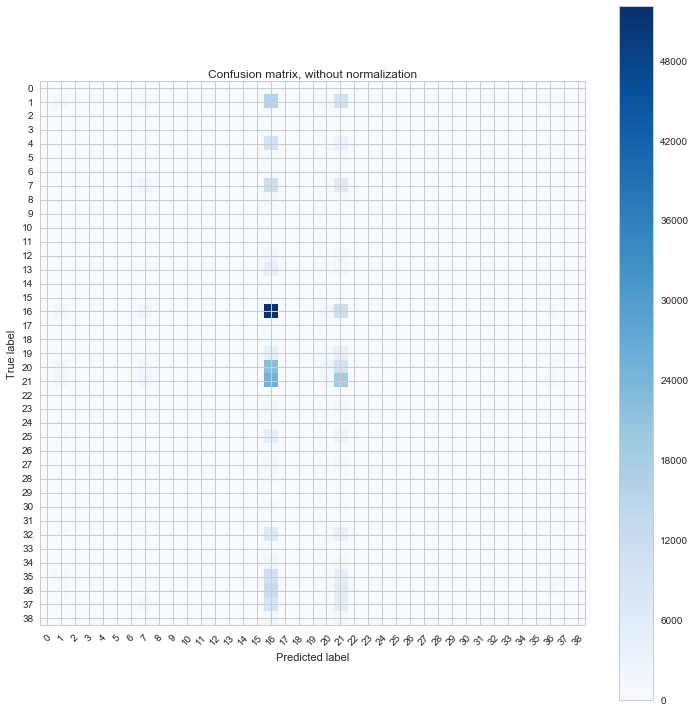

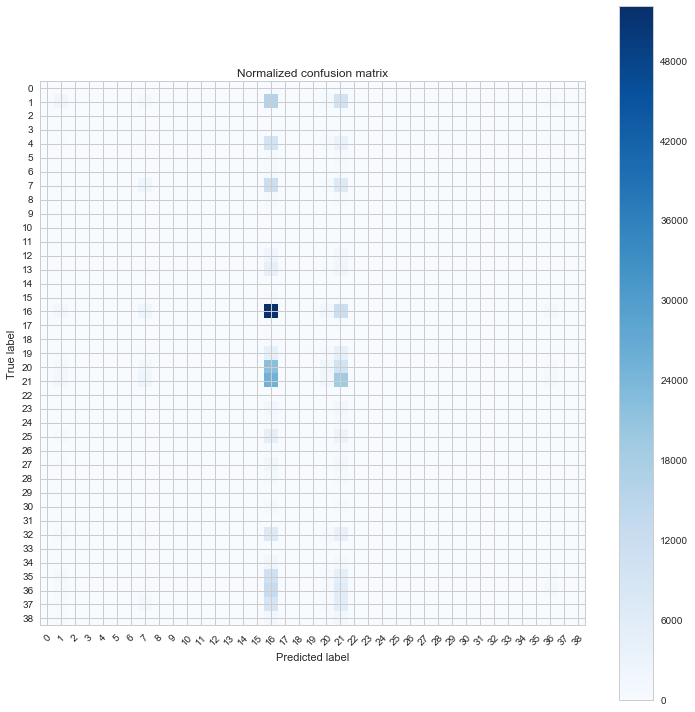

In [102]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=categories_encoded, 
                      title='Confusion matrix, without normalization')

# # Plot normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=categories_encoded, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Based on the off-diagonals, the plot for the normalized confusion matrix seems to suggest that (20,16) and (21,16) are doing poorly.

In [104]:
print (16, categories[16])
print (20, categories[20])
print (21, categories[21])

16 LARCENY/THEFT
20 NON-CRIMINAL
21 OTHER OFFENSES


This suggests that "Non-Criminal" and "Other Offenses" are being incorrectly labeled as "Larcency/Theft".

In [106]:
# As mentioned before, here are the top 5 crimes:
print ("Training Data: Top 5 crimes")
print (category_count.sort_values(by="Dates", ascending=False)[:5])
print ("")

Training Data: Top 5 crimes
          Category   Dates
16   LARCENY/THEFT  174900
21  OTHER OFFENSES  126182
20    NON-CRIMINAL   92304
1          ASSAULT   76876
7    DRUG/NARCOTIC   53971



In [107]:
# Printing the index for each crime
for item in enumerate(categories):
    print (item)

(0, 'ARSON')
(1, 'ASSAULT')
(2, 'BAD CHECKS')
(3, 'BRIBERY')
(4, 'BURGLARY')
(5, 'DISORDERLY CONDUCT')
(6, 'DRIVING UNDER THE INFLUENCE')
(7, 'DRUG/NARCOTIC')
(8, 'DRUNKENNESS')
(9, 'EMBEZZLEMENT')
(10, 'EXTORTION')
(11, 'FAMILY OFFENSES')
(12, 'FORGERY/COUNTERFEITING')
(13, 'FRAUD')
(14, 'GAMBLING')
(15, 'KIDNAPPING')
(16, 'LARCENY/THEFT')
(17, 'LIQUOR LAWS')
(18, 'LOITERING')
(19, 'MISSING PERSON')
(20, 'NON-CRIMINAL')
(21, 'OTHER OFFENSES')
(22, 'PORNOGRAPHY/OBSCENE MAT')
(23, 'PROSTITUTION')
(24, 'RECOVERED VEHICLE')
(25, 'ROBBERY')
(26, 'RUNAWAY')
(27, 'SECONDARY CODES')
(28, 'SEX OFFENSES FORCIBLE')
(29, 'SEX OFFENSES NON FORCIBLE')
(30, 'STOLEN PROPERTY')
(31, 'SUICIDE')
(32, 'SUSPICIOUS OCC')
(33, 'TREA')
(34, 'TRESPASS')
(35, 'VANDALISM')
(36, 'VEHICLE THEFT')
(37, 'WARRANTS')
(38, 'WEAPON LAWS')


Based off of the above, we can see that the indexes for the top 5 crime are as follows:
- (16, 'LARCENY/THEFT')
- (21, 'OTHER OFFENSES')
- (20, 'NON-CRIMINAL')
- (1, 'ASSAULT')
- (7, 'DRUG/NARCOTIC')

In [108]:
# For the top 5 crimes, find the biggest category it is being confused with
for crime in [16, 21, 20, 1, 7]:
    max = 0
    for item in enumerate(cm_normalized[crime]):
        if (item[0] != crime) & (item[1] > max):
            max = item[1]
            max_index = item[0]
        else:
            continue
    print (categories[crime], "is being confused as", categories[max_index])

LARCENY/THEFT is being confused as OTHER OFFENSES
OTHER OFFENSES is being confused as LARCENY/THEFT
NON-CRIMINAL is being confused as LARCENY/THEFT
ASSAULT is being confused as LARCENY/THEFT
DRUG/NARCOTIC is being confused as LARCENY/THEFT


### Iteration 3

#### Adding in Other Time and Location Features

This may result in better predictions

In [448]:
# Get binarized weekdays, neighborhoods, and hours
days = pd.get_dummies(train_data_full.DayOfWeek)
neighborhoods = pd.get_dummies(train_data_full.Neighborhood)
dayofmonth = pd.get_dummies(train_data_full.DayOfMonth)
timecat = pd.get_dummies(train_data_full.TimeCat_Str)

In [449]:
# Build new array
trainData3 = pd.concat([days, neighborhoods, dayofmonth, timecat], axis=1)
trainData3['crime']=crime

In [453]:
feature_day = list(set(np.unique(train_data_full["DayOfWeek"])))
feature_neighborhood = list(set(train_data_full["Neighborhood"]))
feature_dayofmonth = list(set(np.unique(train_data_full["DayOfMonth"])))
feature_timecat = list(set(np.unique(train_data_full["TimeCat_Str"])))
features3 = feature_day + feature_neighborhood + feature_dayofmonth + feature_timecat 
features3.remove(None)

print (features3)
feature_labels3 = ['Day of Week', 'Neighborhood', 'Day of Month', 'Time Category']

['Monday', 'Saturday', 'Friday', 'Wednesday', 'Sunday', 'Thursday', 'Tuesday', 'Van Ness - Civic Center', 'Forest Knolls', 'Balboa Terrace', 'Diamond Heights', 'Nob Hill', 'Lake', 'Mission Terrace', 'North Beach', 'Treasure Island', 'Mission Bay', 'Lower Pacific Heights', 'Lakeshore', 'Western Addition', 'Inner Sunset', 'Bayview', 'Golden Gate Heights', 'Inner Richmond', 'Pacific Heights', 'Parnassus - Ashbury', 'Glen Park', 'Chinatown', 'Clarendon Heights', 'Miraloma Park', 'Westwood Highlands', 'Potrero Hill', 'Lakeside', 'Parkside', 'Crocker Amazon', 'Hunters Point', 'Haight-Ashbury', 'West Portal', 'Twin Peaks', 'Financial District', 'Forest Hill', 'Merced Heights', 'Cow Hollow', 'Yerba Buena Island', 'Sherwood Forest', 'Buena Vista Park', 'South Beach', 'Stonestown', 'Lone Mountain', 'Ingleside Heights', 'Presidio', 'Jordan Park - Laurel Heights', 'Corona Heights', 'Outer Richmond', 'Outer Sunset', 'Russian Hill', 'Mount Davidson Manor', 'Inner Parkside', 'Duboce Triangle', 'Centr

In [454]:
training3, validation3 = train_test_split(trainData3, train_size=.60)

In [455]:
# Naive bayes
alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0, 15.0, 20.0, 30.0, 40.0, 50.0, 80.0, 100.0, 200.0]}
nb3 = best_e_nb(alphas,training3[features3],training3['crime'])  #get the best alpha via grid search
alpha = nb3.best_params_['alpha']
model_NB3 = BernoulliNB(alpha=alpha,binarize=0.5)
model_NB3.fit(training3[features3], training3['crime'])
predicted_NB3 = np.array(model_NB3.predict_proba(validation3[features3]))
log_loss(validation3['crime'], predicted_NB3)

2.6206013855129253

In [456]:
# Logistic regression
#GridSearch takes too long for LR, we chose C of 1.0
C = 1.0
model_LR3 = LogisticRegression(C=C)
model_LR3.fit(training3[features3], training3['crime'])
predicted_LR3 = np.array(model_LR3.predict_proba(validation3[features3]))
log_loss(validation3['crime'], predicted_LR3) 

2.567847124204818

### Iteration 4

#### Adding Year and Month

In [467]:
# Get binarized weekdays, neighborhoods, and hours
days = pd.get_dummies(train_data_full.DayOfWeek)
neighborhoods = pd.get_dummies(train_data_full.Neighborhood)
hour = pd.get_dummies(train_data_full.Hour)

In [468]:
# Create year and month features
year = train_data_full.Dates.dt.year
year = pd.get_dummies(year)

month = pd.get_dummies(train_data_full.Month_Str)

In [469]:
# Build new array
trainData4 = pd.concat([days, neighborhoods, hour, month], axis=1)
trainData4['crime']=crime

In [471]:
feature_day = list(set(np.unique(train_data_full["DayOfWeek"])))
feature_neighborhood = list(set((train_data_full["Neighborhood"])))
feature_hour = list(set((train_data_full["Hour"])))
feature_year = list(year.columns)
feature_month = list(set((train_data_full["Month_Str"])))
features4 = feature_day + feature_neighborhood + feature_hour + feature_month
features4.remove(None)

print (features4)
feature_labels4 = ['Day of Week', 'Neighborhood', 'Hour', 'Month']

['Monday', 'Saturday', 'Friday', 'Wednesday', 'Sunday', 'Thursday', 'Tuesday', 'Van Ness - Civic Center', 'Forest Knolls', 'Balboa Terrace', 'Diamond Heights', 'Nob Hill', 'Lake', 'Mission Terrace', 'North Beach', 'Treasure Island', 'Mission Bay', 'Lower Pacific Heights', 'Lakeshore', 'Western Addition', 'Inner Sunset', 'Bayview', 'Golden Gate Heights', 'Inner Richmond', 'Pacific Heights', 'Parnassus - Ashbury', 'Glen Park', 'Chinatown', 'Clarendon Heights', 'Miraloma Park', 'Westwood Highlands', 'Potrero Hill', 'Lakeside', 'Parkside', 'Crocker Amazon', 'Hunters Point', 'Haight-Ashbury', 'West Portal', 'Twin Peaks', 'Financial District', 'Forest Hill', 'Merced Heights', 'Cow Hollow', 'Yerba Buena Island', 'Sherwood Forest', 'Buena Vista Park', 'South Beach', 'Stonestown', 'Lone Mountain', 'Ingleside Heights', 'Presidio', 'Jordan Park - Laurel Heights', 'Corona Heights', 'Outer Richmond', 'Outer Sunset', 'Russian Hill', 'Mount Davidson Manor', 'Inner Parkside', 'Duboce Triangle', 'Centr

In [472]:
features4.remove(None)

In [473]:
training4, validation4 = train_test_split(trainData4, train_size=.60)

In [474]:
# Naive bayes
alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0, 15.0, 20.0, 30.0, 40.0, 50.0, 80.0, 100.0, 200.0]}
nb4 = best_e_nb(alphas,training4[features4],training4['crime'])  #get the best alpha via grid search
alpha = nb4.best_params_['alpha']
model_NB4 = BernoulliNB(alpha=alpha,binarize=0.5)
model_NB4.fit(training4[features4], training4['crime'])
predicted_NB4 = np.array(model_NB4.predict_proba(validation4[features4]))
log_loss(validation4['crime'], predicted_NB4) 

2.5857616215799686

In [475]:
# Logistic regression
#GridSearch takes too long for LR, we chose C of 1.0
C = 1.0
model_LR4 = LogisticRegression(C=C)
model_LR4.fit(training4[features4], training4['crime'])
predicted_LR4 = np.array(model_LR4.predict_proba(validation4[features4]))
log_loss(validation4['crime'], predicted_LR4) 

2.5556164066890226

### Iteration 5

#### With XY Coordinates

In [276]:
trainData5 = train_data_full[['X', 'Y']]
trainData5['crime']=crime
features5 = ['X', 'Y']
feature_labels5 = ['X', 'Y']

In [277]:
trainData5.head()

,X,Y,crime
0,-122.425891675136,37.7745985956747,37
1,-122.425891675136,37.7745985956747,21
2,-122.42436302145,37.8004143219856,21
3,-122.42699532676599,37.80087263276921,16
4,-122.438737622757,37.771541172057795,16


In [278]:
training5, validation5 = train_test_split(trainData5, train_size=.60)

In [317]:
# Logistic regression
#GridSearch takes too long for LR, we chose C of 1.0
C = 1.0
model_LR5 = LogisticRegression(C=C)
model_LR5.fit(trainData5[['X','Y']], trainData5['crime'])
predicted_LR5 = np.array(model_LR5.predict_proba(validation5[['X','Y']]))
log_loss(validation5['crime'], predicted_LR5) 

2.6749876243931006

### Iteration 6

#### NB with Day of Week, Neighborhood, Hour, Season

In [476]:
# Get binarized weekdays, neighborhoods, hours, seasons
days = pd.get_dummies(train_data_full.DayOfWeek)
neighborhoods = pd.get_dummies(train_data_full.Neighborhood)
hour = pd.get_dummies(train_data_full.Hour)
season = pd.get_dummies(train_data_full.Season_Str)

In [477]:
# Build new array
trainData6 = pd.concat([days, neighborhoods, hour, season], axis=1)
trainData6['crime']=crime

In [478]:
feature_day = list(set(np.unique(train_data_full["DayOfWeek"])))
feature_neighborhood = list(set(train_data_full["Neighborhood"]))
feature_hour = list(set(train_data_full["Hour"]))
feature_season = list(set(np.unique(train_data_full["Season_Str"])))
features6 = feature_day + feature_neighborhood + feature_hour + feature_season
features6.remove(None)

print (features6)

feature_labels6 = ['Day of Week', 'Neighborhood', 'Hour', 'Season']

['Monday', 'Saturday', 'Friday', 'Wednesday', 'Sunday', 'Thursday', 'Tuesday', 'Van Ness - Civic Center', 'Forest Knolls', 'Balboa Terrace', 'Diamond Heights', 'Nob Hill', 'Lake', 'Mission Terrace', 'North Beach', 'Treasure Island', 'Mission Bay', 'Lower Pacific Heights', 'Lakeshore', 'Western Addition', 'Inner Sunset', 'Bayview', 'Golden Gate Heights', 'Inner Richmond', 'Pacific Heights', 'Parnassus - Ashbury', 'Glen Park', 'Chinatown', 'Clarendon Heights', 'Miraloma Park', 'Westwood Highlands', 'Potrero Hill', 'Lakeside', 'Parkside', 'Crocker Amazon', 'Hunters Point', 'Haight-Ashbury', 'West Portal', 'Twin Peaks', 'Financial District', 'Forest Hill', 'Merced Heights', 'Cow Hollow', 'Yerba Buena Island', 'Sherwood Forest', 'Buena Vista Park', 'South Beach', 'Stonestown', 'Lone Mountain', 'Ingleside Heights', 'Presidio', 'Jordan Park - Laurel Heights', 'Corona Heights', 'Outer Richmond', 'Outer Sunset', 'Russian Hill', 'Mount Davidson Manor', 'Inner Parkside', 'Duboce Triangle', 'Centr

In [479]:
training6, validation6 = train_test_split(trainData6, train_size=.60)

In [480]:
# Naive bayes
alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0, 15.0, 20.0, 30.0, 40.0, 50.0, 80.0, 100.0, 200.0]}
nb6 = best_e_nb(alphas,training6[features6],training6['crime'])  #get the best alpha via grid search
alpha = nb6.best_params_['alpha']
model_NB6 = BernoulliNB(alpha=alpha,binarize=0.5)
model_NB6.fit(training6[features6], training6['crime'])
predicted_NB6 = np.array(model_NB6.predict_proba(validation6[features6]))
log_loss(validation6['crime'], predicted_NB6) 

2.5688077661076298

In [481]:
# Logistic regression
#GridSearch takes too long for LR, we chose C of 1.0
C = 1.0
model_LR6 = LogisticRegression(C=C)
model_LR6.fit(training6[features6], training6['crime'])
predicted_LR6 = np.array(model_LR6.predict_proba(validation6[features6]))
log_loss(validation6['crime'], predicted_LR6) 

2.5555827427864388

### Iteration 7

#### Day of Week, Neighborhood, Hour, XNorm, YNorm

In [489]:
# Get binarized weekdays, neighborhoods, hours
days = pd.get_dummies(train_data_full.DayOfWeek)
neighborhoods = pd.get_dummies(train_data_full.Neighborhood)
hour = pd.get_dummies(train_data_full.Hour)

In [490]:
xnorm = train_data_full['XNorm']
ynorm = train_data_full['YNorm']

In [491]:
# Build new array
trainData7 = pd.concat([days, neighborhoods, hour, xnorm, ynorm], axis=1)
trainData7['crime']=crime

In [492]:
trainData7.head()

,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Anza Vista,Balboa Terrace,Bayview,...,3:00,4:00,5:00,6:00,7:00,8:00,9:00,XNorm,YNorm,crime
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043578,0.001276,37
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043578,0.001276,21
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.044337,0.001770,21
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043030,0.001778,16
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.037198,0.001217,16


In [493]:
feature_day = list(set(np.unique(train_data_full["DayOfWeek"])))
feature_neighborhood = list(set(train_data_full["Neighborhood"]))
feature_hour = list(set(train_data_full["Hour"]))
features7 = feature_day + feature_neighborhood + feature_hour 
features7.append("XNorm")
features7.append("YNorm")
features7.remove(None)

print (features7)

feature_labels7 = ['Day of Week', 'Neighborhood', 'Hour', 'XNorm', 'YNorm']

['Monday', 'Saturday', 'Friday', 'Wednesday', 'Sunday', 'Thursday', 'Tuesday', 'Van Ness - Civic Center', 'Forest Knolls', 'Balboa Terrace', 'Diamond Heights', 'Nob Hill', 'Lake', 'Mission Terrace', 'North Beach', 'Treasure Island', 'Mission Bay', 'Lower Pacific Heights', 'Lakeshore', 'Western Addition', 'Inner Sunset', 'Bayview', 'Golden Gate Heights', 'Inner Richmond', 'Pacific Heights', 'Parnassus - Ashbury', 'Glen Park', 'Chinatown', 'Clarendon Heights', 'Miraloma Park', 'Westwood Highlands', 'Potrero Hill', 'Lakeside', 'Parkside', 'Crocker Amazon', 'Hunters Point', 'Haight-Ashbury', 'West Portal', 'Twin Peaks', 'Financial District', 'Forest Hill', 'Merced Heights', 'Cow Hollow', 'Yerba Buena Island', 'Sherwood Forest', 'Buena Vista Park', 'South Beach', 'Stonestown', 'Lone Mountain', 'Ingleside Heights', 'Presidio', 'Jordan Park - Laurel Heights', 'Corona Heights', 'Outer Richmond', 'Outer Sunset', 'Russian Hill', 'Mount Davidson Manor', 'Inner Parkside', 'Duboce Triangle', 'Centr

In [494]:
training7, validation7 = train_test_split(trainData7, train_size=.60)

In [495]:
# Logistic regression
#GridSearch takes too long for LR, we chose C of 1.0
C = 1.0
model_LR7 = LogisticRegression(C=C)
model_LR7.fit(training7[features7], training7['crime'])
predicted_LR7 = np.array(model_LR7.predict_proba(validation7[features7]))
log_loss(validation7['crime'], predicted_LR7) 

2.5546003558274784

## VII. Overall Results



In [496]:
cols = ['Model', 'Model Code Name', 'Alpha/C', 'Features', 'Log Loss']
rows = [['Naive Bayes', 'model_NB1', nb1.best_params_['alpha'], feature_labels1, log_loss(validation1['crime'], predicted_NB1)]
       ,['Logistic Regression', 'model_LR1', '1.0', feature_labels1, log_loss(validation1['crime'], predicted_LR1)]
       ,['Naive Bayes', 'model_NB2', nb2.best_params_['alpha'], feature_labels2, log_loss(validation2['crime'], predicted_NB2)]
       ,['Logistic Regression', 'model_LR2', '1.0', feature_labels2, log_loss(validation2['crime'], predicted_LR2)]
       ,['Naive Bayes', 'model_NB3', nb3.best_params_['alpha'], feature_labels3, log_loss(validation3['crime'], predicted_NB3)]
       ,['Logistic Regression', 'model_LR3', '1.0', feature_labels3, log_loss(validation3['crime'], predicted_LR3)]
       ,['Naive Bayes', 'model_NB4', nb4.best_params_['alpha'], feature_labels4, log_loss(validation4['crime'], predicted_NB4)]
       ,['Logistic Regression', 'model_LR4', '1.0', feature_labels4, log_loss(validation4['crime'], predicted_LR4)]
       ,['Logistic Regression', 'model_LR5', '1.0', feature_labels5, log_loss(validation5['crime'], predicted_LR5)]
       ,['Naive Bayes', 'model_NB6', nb6.best_params_['alpha'], feature_labels6, log_loss(validation6['crime'], predicted_NB6)]
       ,['Logistic Regression', 'model_LR6', '1.0', feature_labels6, log_loss(validation6['crime'], predicted_LR6)]
       ,['Logistic Regression', 'model_LR7', '1.0', feature_labels7, log_loss(validation7['crime'], predicted_LR7)]]
#sort by log loss in ascending order
rows = sorted(rows, key=lambda x: x[4])

List of models, model parameters, features used and the resulting log loss value
Sorted in Log Loss ascending order to show best model based on log loss at the top


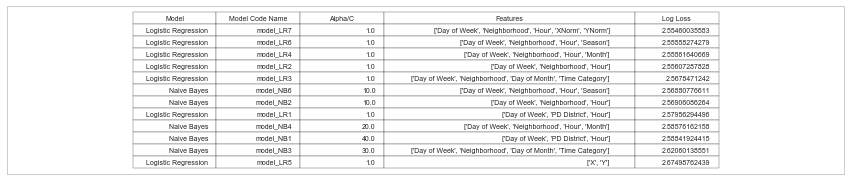

In [497]:
fig=plt.figure(figsize=(15,3))
ax = fig.add_subplot(111)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
colLabels=(cols)
the_table = ax.table(cellText=rows,
              colLabels=colLabels,
              loc='center',colWidths=[.1,.1,.1,.3,.1])
print("List of models, model parameters, features used and the resulting log loss value")
print("Sorted in Log Loss ascending order to show best model based on log loss at the top")
plt.show()

## VIII. Appy best model to test data

### Kaggle Log Loss Evaluation:   
### Kaggle Rank:


In [499]:
# Add additional features to test data

#Add neighborhood to test data
test_data['Neighborhood'] = test_data.apply(lambda x: neighborhood(nhood_list,x['X'],x['Y']),axis=1)

#convert Dates to datetime
test_data['FinalDate'] = pd.to_datetime(test_data['Dates'], format='%Y-%m-%d %H:%M:%S')

#apply the needed functions
test_data['Hour'] = test_data['FinalDate'].apply(lambda x: str(x.hour) + ":00")

#Normalize and Standardize Date and X,Y
test_data = normalize(test_data['FinalDate'], test_data, 'DateNorm')
test_data = standardize(test_data['FinalDate'], test_data, 'DateStand')
test_data = normalize(test_data['X'], test_data, 'XNorm')
test_data = standardize(test_data['X'], test_data, 'XStand')
test_data = normalize(test_data['Y'], test_data, 'YNorm')
test_data = standardize(test_data['Y'], test_data, 'YStand')
test_data = standardize(test_data['DateNorm'], test_data, 'DateNS')
test_data = standardize(test_data['XNorm'], test_data, 'XNS')
test_data = standardize(test_data['YNorm'], test_data, 'YNS')

In [510]:
# Get binarized weekdays, neighborhoods, hours
days = pd.get_dummies(test_data.DayOfWeek)
neighborhoods = pd.get_dummies(test_data.Neighborhood)
hour = pd.get_dummies(test_data.Hour)
xnorm = test_data['XNorm']
ynorm = test_data['YNorm']

# Build new array
testData = pd.concat([days, neighborhoods, hour, xnorm, ynorm], axis=1)

test_data_final = testData[features7]
predicted = model_LR7.predict_proba(test_data_final)

results=pd.DataFrame(predicted, columns=leCrime.classes_)


In [512]:
results.to_csv('testResults_final1.csv', sep=',', columns = leCrime.classes_, index = True, index_label = 'ID')